In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import oh_to_12pluslog, mu, get_velocity_profile, get_velocity_evolution, boxcarsmoothtrend
from src.simulations.models.utils import sinusoid, tilted_sinusoid
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [6]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/equilibrium-paper/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

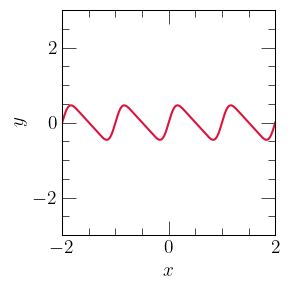

In [11]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_xlim([-2, 2])
ax.set_ylim([-3, 3])

ts = tilted_sinusoid(skewness = 5, amplitude = 0.25)
# ts = sinusoid()
xvals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
yvals = [ts(x) for x in xvals]
ax.plot(xvals, yvals, c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

In [53]:
output = vice.output("../outputs/angular-momentum-dilution/betaphiin0p7-oscil-0p1-0p4Gyr-skew5")
# output = vice.output("../outputs/angular-momentum-dilution/betaphiin0p7")

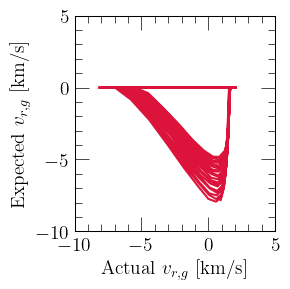

In [54]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Actual $v_{r,g}$ [km/s]")
ax.set_ylabel(r"Expected $v_{r,g}$ [km/s]")
ax.set_xlim([-10, 5])
# ax.set_xlim([-1, 0])
ax.set_ylim(ax.get_xlim())
# ax.set_xscale("log")
# ax.set_yscale("log")

def plot_comparison(output, start = 8, radius = 8, zone_width = 0.1, betaphiin = 0.7, **kwargs):
    zone = output.zones["zone%d" % (int(radius / zone_width))]
    diff = [abs(_ - start) for _ in zone.history["lookback"]]
    idx = diff.index(min(diff))
    expected = []
    lookback = zone.history["lookback"][idx:]
    for i in range(idx, len(zone.history["time"])):
        expected.append(-radius * 1.e9 * zone.history["ifr"][i] / zone.history["mgas"][i] * (1 - betaphiin))
    lookback, vgas = get_velocity_evolution(output, radius, zone_width = zone_width)
    # print(list(zip(lookback, vgas)))
    diff = [abs(_ - start) for _ in lookback]
    idx = diff.index(min(diff))
    vgas = vgas[idx:]
    # print(vgas)
    # print(expected)
    ax.plot(vgas, expected, **kwargs)

plot_comparison(output, c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

In [39]:
outputs = [
    "../outputs/oscillatory/mean-1-amp10-period0p2Gyr-sfroscil-amp0p5-period0p2Gyr",
    "../outputs/oscillatory/mean-1-amp10-period0p2Gyr-sfroscil-amp0p5-period0p2Gyr-phase180",
    "../outputs/oscillatory/mean-1-amp10-period0p2Gyr",
    "../outputs/constant/vgas-1-centraloutflow"
    # "../outputs/oscillatory/mean-0p5-amp10-period0p2Gyr-sfroscil-amp0p5-period0p2Gyr",
    # "../outputs/oscillatory/mean-0p5-amp10-period0p2Gyr-sfroscil-amp0p5-period0p2Gyr-phase180",
    # "../outputs/oscillatory/mean-0p5-amp10-period0p2Gyr",
    # "../outputs/constant/vgas-0p5",
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

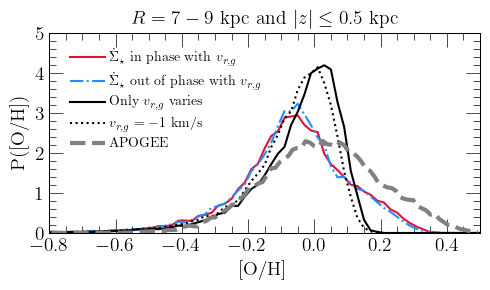

In [42]:
# COLORS = ["black", "black", "crimson", "dodgerblue"]
# LINESTYLES = [":", "-", "-", "-."]
COLORS = ["crimson", "dodgerblue", "black", "black"]
LINESTYLES = ["-", "-.", "-", ":"]
LABELS = [
    r"$\dot\Sigma_\star$ in phase with $v_{r,g}$",
    r"$\dot\Sigma_\star$ out of phase with $v_{r,g}$",
    r"Only $v_{r,g}$ varies",
    r"$v_{r,g} = -1$ km/s"]
MIN_RGAL = 7
MAX_RGAL = 9
MIN_ABSZ = 0
MAX_ABSZ = 0.5

fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"[O/H]")
ax.set_ylabel(r"P([O/H])")
ax.set_xlim([-0.8, 0.5])
ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4])
ax.set_ylim([0, 5])
ax.set_title(r"$R = 7 - 9$ kpc and $\left|z\right| \leq 0.5$ kpc", fontsize = 14)

def plot_mdf(ax, output, min_rgal, max_rgal, min_absz, max_absz, zone_width = 0.1, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(min_rgal / zone_width)).filter(
        "zone_final", "<", int(max_rgal / zone_width)).filter(
        "absz", ">=", min_absz).filter(
        "absz", "<=", max_absz).filter(
        "mass", ">=", 1)
    dist, bins = np.histogram(stars["[o/h]"], range = [-1, 1], bins = 100, weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    # xvals = [x + 0.1 for x in xvals]
    ax.plot(xvals, dist, **kwargs)

def plot_local_distribution(ax, stars, **kwargs):
    sub = stars.filter(
        "galr", ">=", 7).filter(
        "galr", "<=", 9).filter(
        "absz", "<=", 0.5)
    hist, bins = np.histogram(sub["o_h"], bins = 100, range = ax.get_xlim(), density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    # ax.step(xvals, hist, where = "mid", **kwargs)
    ax.plot(xvals, hist, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_mdf(ax, outputs[i], MIN_RGAL, MAX_RGAL, MIN_ABSZ, MAX_ABSZ, **kwargs)
plot_local_distribution(ax, sample, c = named_colors()["grey"], linestyle = "--", linewidth = 3, label = "APOGEE")

# ax.errorbar(0.2, 3.5, xerr = [0.1], color = named_colors()["black"])
# ax.text(0.2, 3, "Yield\nUncertainties", fontsize = 12, horizontalalignment = "center", verticalalignment = "center")

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.02, 0.98),
    "handlelength": 1.8,
    "fontsize": 10,
    "handlelength": 2.5
}
ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./oscil/mdfs-solarcircle.%s" % (ext), **kwargs)
plt.show()

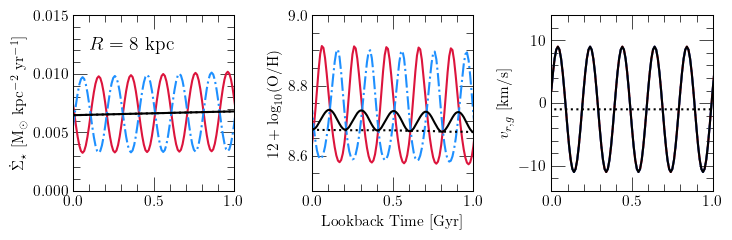

In [45]:
# COLORS = ["black", "black", "crimson", "dodgerblue"]
# LINESTYLES = [":", "-", "-", "--"]
COLORS = ["crimson", "dodgerblue", "black", "black"]
LINESTYLES = ["-", "-.", "-", ":"]
RADIUS = 8

fig = plt.figure(figsize = (7.5, 2.5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
# ax1.set_yscale("log")
# ax2.set_yscale("log")
ax2.set_xlabel(r"Lookback Time [Gyr]", fontsize = 11)
ax1.set_ylabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]", fontsize = 11)
ax2.set_ylabel(r"$12 + \log_{10}$(O/H)", fontsize = 11)
# ax2.set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax3.set_ylabel(r"$v_{r,g}$ [km/s]", fontsize = 11)
for ax in [ax1, ax2, ax3]:
    ax.set_xlim([0, 1])
    ax.tick_params(labelsize = 11)
ax1.set_ylim([0, 0.015])
ax2.set_ylim([8.5, 9.0])
ax3.set_ylim([-14, 14])
ax2.set_yticks([8.6, 8.8, 9])
# ax1.yaxis.set_major_formatter(fsf("%g"))
# ax1.yaxis.set_minor_formatter(fsf("%g"))
# ax1.
ax1.text(0.1, 0.012, r"$R = 8$ kpc", fontsize = 14)

def plot_evolution(ax_sfr, ax_oh, ax_v, output, radius, zone_width = 0.1, **kwargs):
    area = np.pi * ((radius + zone_width)**2 - radius**2)
    zone = output.zones["zone%d" % (int(radius / zone_width))]
    lookback = zone.history["lookback"]
    sigma_sfr = [sfr / area for sfr in zone.history["sfr"]]
    oh = zone.history["[o/h]"]
    oh = oh_to_12pluslog(oh)
    ax_sfr.plot(lookback, sigma_sfr, **kwargs)
    ax_oh.plot(lookback, oh, **kwargs)
    lookback, vgas = get_velocity_evolution(output, radius, zone_width = zone_width)
    ax_v.plot(lookback, vgas, **kwargs)

# # def plot_evolution(ax_sfr, ax_ifr, ax_v, output, radius, zone_width = 0.1, **kwargs):
# def plot_evolution(ax_oh, ax_ifr, ax_v, output, radius, zone_width = 0.1, **kwargs):
#     area = np.pi * ((radius + zone_width)**2 - radius**2)
#     zone = output.zones["zone%d" % (int(radius / zone_width))]
#     lookback = zone.history["lookback"]
#     # sigma_sfr = [sfr / area for sfr in zone.history["sfr"]]
#     oh = zone.history["[o/h]"]
#     sigma_ifr = [ifr / area for ifr in zone.history["ifr"]]
#     # ax_sfr.plot(lookback, sigma_sfr, **kwargs)
#     ax_oh.plot(lookback, oh, **kwargs)
#     ax_ifr.plot(lookback, sigma_ifr, **kwargs)
#     lookback, vgas = get_velocity_evolution(output, radius, zone_width = zone_width)
#     ax_v.plot(lookback, [-v for v in vgas], **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i]
    }
    plot_evolution(ax1, ax2, ax3, outputs[i], RADIUS, **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./oscil/solarcircle-evol.%s" % (ext), **kwargs)
# negative_log(ax3)
plt.show()